In [4]:
print("check")

check


In [ ]:
THIS IS TRAINED IN KAGGLE THIS IS THE SAME CODE AS OTHER JUST IN SINGLE NOTEBOOK REFER UI FOR IMPLEMENTATION 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Force CPU if needed (for lightweight/CPU-only requirement)
# device = torch.device('cpu')
# print("Forced to use CPU")


Using device: cuda
PyTorch version: 2.6.0+cu124


In [6]:
# Load labels.csv
df = pd.read_csv('/kaggle/input/dataglobalfinal/images.csv',keep_default_na=False)
print(f"Total samples: {len(df)}")
print(f"\nSplit distribution:")
print(df['split'].value_counts())
print(f"\nClass distribution:")
print(df['class_label'].value_counts())
print(f"\nUnique classes: {len(df['class_label'].unique())}")
print(f"Classes: {sorted(df['class_label'].unique())}")
print(f"\nFirst few rows:")
df.head()


Total samples: 11880

Split distribution:
split
train    8863
val      1713
test     1304
Name: count, dtype: int64

Class distribution:
class_label
pen                536
backpack           360
mouse              358
notebook           320
earphones          303
                  ... 
water_bottle_7       4
water_bottle_5       3
water_bottle_4       3
water_bottle_11      2
water_bottle_8       2
Name: count, Length: 197, dtype: int64

Unique classes: 197
Classes: ['Clothing_wallet', 'Cosmetics_lipstick', 'Cup', 'Earpods_headphones', 'Electronics_Accessories_mouse', 'Footwear_Sneakers', 'Medical_pill_strip', 'Personal_Care_shampoo_bottle', 'Shampoo_bottle', 'Stationery_Pen', 'Stationery_notebook', 'Tableware_Water_Bottle', 'Tools_screwdriver', 'Travel_backpack', 'Travel_bagpack', 'backpack', 'bathroom_bucket', 'bathroom_comb', 'bathroom_handwashing', 'bathroom_loofah', 'bathroom_razor', 'bathroom_shampoo_bottle', 'bathroom_soapbox', 'bathroom_tap', 'bathroom_tongue_cleaner', 'bathroo

,image_path,class_label,attributes,caption,split,instance_id,attr_color,attr_material,attr_condition
0,images/team25_electric_kettle_48.jpg,small_appliances_electric_kettle,color:green;material:metal;condition:new;shape...,wipro electric kettle with temperature control...,train,electric_kettle_J_3,green,metal,new
1,images/Team12_Food_storage_Dishes_016.jpg,food_storage_dishes,shape:circular;colour:blue;material:ceramic,A circular blue ceramic dishes.,train,TEAM12_Food_storage_Dishes_016,unknown,ceramic,unknown
2,images/team8_shampoo_007.jpg,personal_care_shampoo_bottle,color:white;size:medium;condition:used;materia...,A used medium white plastic shampoo bottle,train,shampoo_C_1,white,plastic,used
3,images/Team1_toothbrush_B_3_428.jpg,toothbrush,color:white;material:plastic;shape:irregular,side profile of a white toothbrush with frayed...,train,Team1_toothbrush_B_3,white,plastic,unknown
4,images/Team1_notebook_D_4_139.jpg,notebook,color:blue;material:paper;shape:rectangular,"blue paper notebook on black surface, tilted left",train,Team1_notebook_D_4,blue,paper,unknown


In [7]:
# Parse attributes
def parse_attributes(attr_string):
    """Parse semicolon-separated attributes"""
    attrs = {}
    if pd.notna(attr_string) and attr_string:
        for pair in attr_string.split(';'):
            if ':' in pair:
                key, value = pair.split(':', 1)
                attrs[key.strip()] = value.strip()
    return attrs

# Extract unique attribute values
all_attributes = {}
for _, row in df.iterrows():
    attrs = parse_attributes(row['attributes'])
    for key, value in attrs.items():
        if key not in all_attributes:
            all_attributes[key] = set()
        all_attributes[key].add(value)

print("Attribute types and their possible values:")
for attr_type, values in sorted(all_attributes.items()):
    print(f"\n{attr_type}: {sorted(values)}")
    print(f"  Count: {len(values)}")


Attribute types and their possible values:

color: ['beige', 'black', 'blue', 'bright yellow', 'brown', 'clear', 'dark blue', 'dark_blue', 'gold', 'golden', 'gray', 'green', 'grey', 'light blue', 'light_green', 'maroon', 'multi-color', 'multicolor', 'neon_green', 'neon_yellow', 'orange', 'orange-brown', 'pink', 'purple', 'red', 'red+blue', 'silver', 'teal', 'transparent', 'unknown', 'violet', 'white', 'yellow']
  Count: 33

colour: ['"Biege"', '"beige"', '"biege"', '"black"', '"blue"', '"brown"', '"dark blue"', '"green"', '"grey"', '"multi_color"', '"multi_colour"', '"orange"', '"pink"', '"purple"', '"red"', '"transparent"', '"white"', '"yellow"', 'black', 'blue', 'brown', 'golden', 'green', 'grey', 'maroon', 'multi-color', 'multi-colored', 'multi-colour', 'orange', 'pink', 'purple', 'red', 'silver', 'transparent', 'white', 'yellow']
  Count: 36

condition: ['"new', '"new"', '"well_maintained', '"well_maintained"', '"worn', '"worn"', 'broken', 'deformed', 'mint', 'new', 'old', 'unknown

In [8]:
# Extract attribute labels for each sample
def extract_attribute_labels(row):
    attrs = parse_attributes(row['attributes'])
    return {
        'color': attrs.get('color', 'unknown'),
        'material': attrs.get('material', 'unknown'),
        'condition': attrs.get('condition', 'unknown')
    }

df[['attr_color', 'attr_material', 'attr_condition']] = df.apply(
    lambda row: pd.Series(extract_attribute_labels(row)), axis=1
)

# Get most common attribute values to determine label space
print("Color distribution:")
print(df['attr_color'].value_counts())
print("\nMaterial distribution:")
print(df['attr_material'].value_counts())
print("\nCondition distribution:")
print(df['attr_condition'].value_counts())


Color distribution:
attr_color
unknown          3131
black            2287
white            1370
blue             1155
green             650
brown             502
red               437
silver            401
yellow            299
pink              298
transparent       235
grey              219
purple            193
gray              146
orange            142
multi-color       133
multicolor        132
dark_blue          30
clear              20
gold               19
teal               15
bright yellow      10
golden             10
maroon              8
orange-brown        6
light_green         5
violet              5
dark blue           5
light blue          5
neon_green          5
neon_yellow         5
beige               1
red+blue            1
Name: count, dtype: int64

Material distribution:
attr_material
plastic              5164
metal                1431
fabric               1056
unknown               893
leather               516
rubber                457
paper                 3

In [9]:
class ImageDataset(Dataset):
    def __init__(self, df, image_dir='/kaggle/input/imagedata2/globaldata/globalimages', transform=None, return_attributes=False,
                 class_encoder=None, color_encoder=None, material_encoder=None, condition_encoder=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.return_attributes = return_attributes
        
        # Encode class labels (share encoders across splits)
        if class_encoder is None:
            self.class_encoder = LabelEncoder()
            self.class_encoder.fit(self.df['class_label'])
        else:
            self.class_encoder = class_encoder
        self.class_labels = self.class_encoder.transform(self.df['class_label'])
        
        # Encode attributes if needed (share encoders across splits)
        if return_attributes:
            if color_encoder is None:
                self.color_encoder = LabelEncoder()
                self.color_encoder.fit(self.df['attr_color'].fillna('unknown'))
            else:
                self.color_encoder = color_encoder
            if material_encoder is None:
                self.material_encoder = LabelEncoder()
                self.material_encoder.fit(self.df['attr_material'].fillna('unknown'))
            else:
                self.material_encoder = material_encoder
            if condition_encoder is None:
                self.condition_encoder = LabelEncoder()
                self.condition_encoder.fit(self.df['attr_condition'].fillna('unknown'))
            else:
                self.condition_encoder = condition_encoder
            
            self.color_labels = self.color_encoder.transform(
                self.df['attr_color'].fillna('unknown')
            )
            self.material_labels = self.material_encoder.transform(
                self.df['attr_material'].fillna('unknown')
            )
            self.condition_labels = self.condition_encoder.transform(
                self.df['attr_condition'].fillna('unknown')
            )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Build path and normalize to handle leading './' and a redundant 'images/' folder
        rel_path = str(self.df.iloc[idx]['image_path']).replace('\\', '/')
        # strip leading './'
        if rel_path.startswith('./'):
            rel_path = rel_path[2:]
        # if paths are like 'images/xxx.jpg' but image_dir already points to globalimages/
        if rel_path.startswith('images/'):
            rel_path = rel_path[len('images/'):]
        img_path = os.path.normpath(os.path.join(self.image_dir, rel_path))
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a blank image if loading fails
            image = Image.new('RGB', (224, 224), color='black')
        
        if self.transform:
            image = self.transform(image)
        
        if self.return_attributes:
            return {
                'image': image,
                'class': torch.tensor(self.class_labels[idx], dtype=torch.long),
                'color': torch.tensor(self.color_labels[idx], dtype=torch.long),
                'material': torch.tensor(self.material_labels[idx], dtype=torch.long),
                'condition': torch.tensor(self.condition_labels[idx], dtype=torch.long),
                'caption': self.df.iloc[idx]['caption'],
                'image_path': self.df.iloc[idx]['image_path']
            }
        else:
            return {
                'image': image,
                'class': torch.tensor(self.class_labels[idx], dtype=torch.long),
                'caption': self.df.iloc[idx]['caption'],
                'image_path': self.df.iloc[idx]['image_path']
            }


In [10]:
# Split data into train, validation, and test sets
train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'val'].copy()
test_df = df[df['split'] == 'test'].copy() if 'test' in df['split'].values else None

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
if test_df is not None:
    print(f"Test samples: {len(test_df)}")
print(f"\nTrain split classes: {train_df['class_label'].nunique()}")
print(f"Val split classes: {val_df['class_label'].nunique()}")
if test_df is not None:
    print(f"Test split classes: {test_df['class_label'].nunique()}")


Train samples: 8863
Validation samples: 1713
Test samples: 1304

Train split classes: 197
Val split classes: 186
Test split classes: 197


In [11]:
# Sanity check: class distribution per split
print("Per-split class distribution (counts):\n")
print("Train:\n", train_df['class_label'].value_counts())
print("\nVal:\n", val_df['class_label'].value_counts())
if 'test_df' in locals() and test_df is not None:
    print("\nTest:\n", test_df['class_label'].value_counts())



Per-split class distribution (counts):

Train:
 class_label
pen                402
backpack           270
mouse              268
notebook           240
earphones          227
                  ... 
water_bottle_2       3
water_bottle_5       2
water_bottle_4       2
water_bottle_8       1
water_bottle_11      1
Name: count, Length: 197, dtype: int64

Val:
 class_label
pen                          80
backpack                     54
mouse                        53
notebook                     48
keyboard                     45
                             ..
clothing_shorts               1
furniture_table               1
stationary_ruler              1
electronics_phone_charger     1
furniture_switchboard         1
Name: count, Length: 186, dtype: int64

Test:
 class_label
pen               54
mouse             37
backpack          36
notebook          32
earphones         31
                  ..
water_bottle_4     1
water_bottle_8     1
water_bottle_6     1
water_bottle_7     1
water_bo

In [13]:
# Define enhanced transforms with better data augmentation for transfer learning
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Slightly larger for better quality
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Better augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Slightly more rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # More aggressive
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33))  # Random erasing for regularization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data
train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'val'].copy()
test_df = df[df['split'] == 'test'].copy() if 'test' in df['split'].values else None

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
if test_df is not None:
    print(f"Test samples: {len(test_df)}")

# IMPORTANT: Fit encoders on ALL data (train + val + test) to ensure all values are included
# This prevents KeyError when validation/test sets contain values not seen in training
from sklearn.preprocessing import LabelEncoder

all_class_encoder = LabelEncoder()
all_class_encoder.fit(df['class_label'])

all_color_encoder = LabelEncoder()
all_color_encoder.fit(df['attr_color'].fillna('unknown'))

all_material_encoder = LabelEncoder()
all_material_encoder.fit(df['attr_material'].fillna('unknown'))

all_condition_encoder = LabelEncoder()
all_condition_encoder.fit(df['attr_condition'].fillna('unknown'))

# Create datasets using shared encoders fitted on all data
train_dataset = ImageDataset(
    train_df, transform=train_transform, return_attributes=True,
    class_encoder=all_class_encoder,
    color_encoder=all_color_encoder,
    material_encoder=all_material_encoder,
    condition_encoder=all_condition_encoder
)
val_dataset = ImageDataset(
    val_df, transform=val_transform, return_attributes=True,
    class_encoder=all_class_encoder,
    color_encoder=all_color_encoder,
    material_encoder=all_material_encoder,
    condition_encoder=all_condition_encoder
)
if test_df is not None:
    test_dataset = ImageDataset(
        test_df, transform=val_transform, return_attributes=True,
        class_encoder=all_class_encoder,
        color_encoder=all_color_encoder,
        material_encoder=all_material_encoder,
        condition_encoder=all_condition_encoder
    )

# Create dataloaders
# Note: num_workers=0 for Windows compatibility (prevents hanging)
import platform
use_workers = 0 if platform.system() == 'Windows' else 2
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=use_workers, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=use_workers, pin_memory=True if torch.cuda.is_available() else False)
if test_df is not None:
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=use_workers, pin_memory=True if torch.cuda.is_available() else False)

print(f"DataLoader settings: batch_size={batch_size}, num_workers={use_workers}")

# Get number of classes and attributes (using encoders fitted on all data)
num_classes = len(all_class_encoder.classes_)
num_colors = len(all_color_encoder.classes_)
num_materials = len(all_material_encoder.classes_)
num_conditions = len(all_condition_encoder.classes_)

print(f"\nNumber of classes: {num_classes}")
print(f"Number of colors: {num_colors}")
print(f"Number of materials: {num_materials}")
print(f"Number of conditions: {num_conditions}")


Train samples: 8863
Validation samples: 1713
Test samples: 1304
DataLoader settings: batch_size=32, num_workers=2

Number of classes: 197
Number of colors: 33
Number of materials: 39
Number of conditions: 14


In [14]:
import timm

class MultiTaskViT(nn.Module):
    """Multi-task Vision Transformer with improved transfer learning for >80% accuracy"""
    
    def __init__(self, model_name='deit_tiny_patch16_224', num_classes=10, 
                 num_colors=10, num_materials=10, num_conditions=5, pretrained=True):
        super(MultiTaskViT, self).__init__()
        
        # Use DeiT-Tiny (smaller model) for faster training
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,  # Remove final classifier
            global_pool='token' if 'deit' in model_name else 'avg'
        )
        
        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]
        
        self.feature_dim = feature_dim
        
        # Enhanced task-specific heads with hidden layers for better learning
        hidden_dim = feature_dim // 2
        self.class_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
        self.color_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_colors)
        )
        self.material_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_materials)
        )
        self.condition_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_conditions)
        )
        
        # Shared dropout
        self.dropout = nn.Dropout(0.1)
        
        # Initialize heads
        self._initialize_heads()
    
    def _initialize_heads(self):
        """Initialize task heads with Xavier initialization"""
        for head in [self.class_head, self.color_head, self.material_head, self.condition_head]:
            for module in head.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)
    
    def freeze_backbone(self):
        """Freeze pretrained backbone for transfer learning"""
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def unfreeze_backbone(self):
        """Unfreeze backbone for fine-tuning"""
        for param in self.backbone.parameters():
            param.requires_grad = True
    
    def forward(self, x, return_features=False):
        # Extract features
        features = self.backbone(x)
        features = self.dropout(features)
        
        if return_features:
            return {
                'features': features,
                'class_logits': self.class_head(features),
                'color_logits': self.color_head(features),
                'material_logits': self.material_head(features),
                'condition_logits': self.condition_head(features)
            }
        
        return {
            'class_logits': self.class_head(features),
            'color_logits': self.color_head(features),
            'material_logits': self.material_head(features),
            'condition_logits': self.condition_head(features)
        }


In [15]:
def train_epoch(model, train_loader, optimizer, criterion_class, criterion_attr, device):
    model.train()
    total_loss = 0
    class_correct = 0
    class_total = 0
    
    class_loss_sum = 0
    attr_loss_sum = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch in progress_bar:
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        colors = batch['color'].to(device)
        materials = batch['material'].to(device)
        conditions = batch['condition'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        # Calculate losses
        class_loss = criterion_class(outputs['class_logits'], classes)
        color_loss = criterion_attr(outputs['color_logits'], colors)
        material_loss = criterion_attr(outputs['material_logits'], materials)
        condition_loss = criterion_attr(outputs['condition_logits'], conditions)
        
        # Weighted combination (emphasize class prediction)
        total_batch_loss = class_loss + 0.5 * (color_loss + material_loss + condition_loss)
        
        total_batch_loss.backward()
        optimizer.step()
        
        total_loss += total_batch_loss.item()
        class_loss_sum += class_loss.item()
        attr_loss_sum += (color_loss.item() + material_loss.item() + condition_loss.item()) / 3
        
        # Calculate accuracy
        _, predicted = torch.max(outputs['class_logits'], 1)
        class_total += classes.size(0)
        class_correct += (predicted == classes).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{total_batch_loss.item():.4f}',
            'acc': f'{100 * class_correct / class_total:.2f}%'
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_class_loss = class_loss_sum / len(train_loader)
    avg_attr_loss = attr_loss_sum / len(train_loader)
    accuracy = 100 * class_correct / class_total
    
    return avg_loss, avg_class_loss, avg_attr_loss, accuracy


In [16]:
def validate(model, val_loader, criterion_class, criterion_attr, device):
    model.eval()
    total_loss = 0
    
    # For metrics
    all_class_preds = []
    all_class_true = []
    all_color_preds = []
    all_color_true = []
    all_material_preds = []
    all_material_true = []
    all_condition_preds = []
    all_condition_true = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            images = batch['image'].to(device)
            classes = batch['class'].to(device)
            colors = batch['color'].to(device)
            materials = batch['material'].to(device)
            conditions = batch['condition'].to(device)
            
            outputs = model(images)
            
            # Losses
            class_loss = criterion_class(outputs['class_logits'], classes)
            color_loss = criterion_attr(outputs['color_logits'], colors)
            material_loss = criterion_attr(outputs['material_logits'], materials)
            condition_loss = criterion_attr(outputs['condition_logits'], conditions)
            
            total_batch_loss = class_loss + 0.5 * (color_loss + material_loss + condition_loss)
            total_loss += total_batch_loss.item()
            
            # Predictions
            _, class_pred = torch.max(outputs['class_logits'], 1)
            _, color_pred = torch.max(outputs['color_logits'], 1)
            _, material_pred = torch.max(outputs['material_logits'], 1)
            _, condition_pred = torch.max(outputs['condition_logits'], 1)
            
            all_class_preds.extend(class_pred.cpu().numpy())
            all_class_true.extend(classes.cpu().numpy())
            all_color_preds.extend(color_pred.cpu().numpy())
            all_color_true.extend(colors.cpu().numpy())
            all_material_preds.extend(material_pred.cpu().numpy())
            all_material_true.extend(materials.cpu().numpy())
            all_condition_preds.extend(condition_pred.cpu().numpy())
            all_condition_true.extend(conditions.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    
    # Calculate metrics
    class_acc = accuracy_score(all_class_true, all_class_preds)
    class_f1 = f1_score(all_class_true, all_class_preds, average='weighted')
    
    color_acc = accuracy_score(all_color_true, all_color_preds)
    color_f1 = f1_score(all_color_true, all_color_preds, average='weighted')
    
    material_acc = accuracy_score(all_material_true, all_material_preds)
    material_f1 = f1_score(all_material_true, all_material_preds, average='weighted')
    
    condition_acc = accuracy_score(all_condition_true, all_condition_preds)
    condition_f1 = f1_score(all_condition_true, all_condition_preds, average='weighted')
    
    return {
        'loss': avg_loss,
        'class_acc': class_acc,
        'class_f1': class_f1,
        'color_acc': color_acc,
        'color_f1': color_f1,
        'material_acc': material_acc,
        'material_f1': material_f1,
        'condition_acc': condition_acc,
        'condition_f1': condition_f1
    }


In [17]:
# Quick test to verify data loading works
print("Testing data loading speed...")
import time
start_time = time.time()
test_batch = next(iter(train_loader))
load_time = time.time() - start_time
print(f"First batch loaded in {load_time:.2f} seconds")
print(f"Batch size: {test_batch['image'].shape[0]}")
print(f"Image shape: {test_batch['image'].shape}")
print(f"Classes in batch: {test_batch['class']}")
print("\nData loading test passed! ✓")
print("(Model forward pass test will be done after model initialization)")


Testing data loading speed...
First batch loaded in 1.86 seconds
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Classes in batch: tensor([126,   8,  65, 138, 184, 114,  28,  28,  45, 130, 175, 118, 100,  49,
        127, 139, 136,  45, 172, 181, 125, 176, 181, 167, 167, 118, 104, 174,
         98, 175, 139, 122])

Data loading test passed! ✓
(Model forward pass test will be done after model initialization)


In [18]:
# Initialize Model 1: DeiT-Tiny
import timm

# Initialize the MultiTaskViT model
model1 = MultiTaskViT(
    model_name='deit_tiny_patch16_224',  # Using DeiT-Tiny for faster training
    num_classes=num_classes,
    num_colors=num_colors,
    num_materials=num_materials,
    num_conditions=num_conditions,
    pretrained=True
)

# Move model to device
model1 = model1.to(device)

# Print model info
print(f"Model initialized: {type(model1).__name__}")
print(f"Feature dimension: {model1.feature_dim}")
print(f"Number of parameters: {sum(p.numel() for p in model1.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model1.parameters() if p.requires_grad):,}")

# Initialize loss functions
criterion_class = nn.CrossEntropyLoss()
criterion_attr = nn.CrossEntropyLoss()

print("\nLoss functions initialized:")
print(f"- Class loss: {type(criterion_class).__name__}")
print(f"- Attribute loss: {type(criterion_attr).__name__}")
print("\nModel ready for training!")



model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Model initialized: MultiTaskViT
Feature dimension: 192
Number of parameters: 5,625,979
Trainable parameters: 5,625,979

Loss functions initialized:
- Class loss: CrossEntropyLoss
- Attribute loss: CrossEntropyLoss

Model ready for training!


In [20]:
# Training utility with train F1
from sklearn.metrics import f1_score

def train_epoch_with_f1(model, train_loader, optimizer, criterion_class, criterion_attr, device):
    model.train()
    total_loss = 0.0
    class_correct = 0
    class_total = 0
    class_loss_sum = 0.0
    attr_loss_sum = 0.0
    all_preds = []
    all_true = []
    
    for batch in tqdm(train_loader, desc='Training'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        colors = batch['color'].to(device)
        materials = batch['material'].to(device)
        conditions = batch['condition'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        class_loss = criterion_class(outputs['class_logits'], classes)
        color_loss = criterion_attr(outputs['color_logits'], colors)
        material_loss = criterion_attr(outputs['material_logits'], materials)
        condition_loss = criterion_attr(outputs['condition_logits'], conditions)
        
        total_batch_loss = class_loss + 0.5 * (color_loss + material_loss + condition_loss)
        total_batch_loss.backward()
        optimizer.step()
        
        total_loss += total_batch_loss.item()
        class_loss_sum += class_loss.item()
        attr_loss_sum += (color_loss.item() + material_loss.item() + condition_loss.item()) / 3.0
        
        _, predicted = torch.max(outputs['class_logits'], 1)
        class_total += classes.size(0)
        class_correct += (predicted == classes).sum().item()
        all_preds.extend(predicted.detach().cpu().numpy())
        all_true.extend(classes.detach().cpu().numpy())
    
    avg_loss = total_loss / max(1, len(train_loader))
    avg_class_loss = class_loss_sum / max(1, len(train_loader))
    avg_attr_loss = attr_loss_sum / max(1, len(train_loader))
    train_acc = 100.0 * class_correct / max(1, class_total)
    train_f1 = f1_score(all_true, all_preds, average='weighted') if class_total > 0 else 0.0
    
    return avg_loss, avg_class_loss, avg_attr_loss, train_acc, train_f1


In [22]:
# Improved two-phase training for DeiT-Small (transfer learning)
from torch.optim.lr_scheduler import CosineAnnealingLR

# Phase 1: freeze backbone, train heads
model1.freeze_backbone()
head_params = list(model1.class_head.parameters()) + \
              list(model1.color_head.parameters()) + \
              list(model1.material_head.parameters()) + \
              list(model1.condition_head.parameters())
optimizer_phase1 = optim.AdamW(head_params, lr=3e-4, weight_decay=0.01)
scheduler_phase1 = CosineAnnealingLR(optimizer_phase1, T_max=8, eta_min=1e-6)

best_f1 = 0.0
history1 = { 'train_loss': [], 'train_acc': [], 'train_f1': [],
             'val_loss': [], 'val_class_acc': [], 'val_class_f1': [] }

print("\n[Phase 1/2] Training heads only...")
for epoch in range(8):
    print(f"\nEpoch {epoch+1}/8")
    train_loss, train_class_loss, train_attr_loss, train_acc, train_f1 = train_epoch_with_f1(
        model1, train_loader, optimizer_phase1, criterion_class, criterion_attr, device
    )
    val_metrics = validate(model1, val_loader, criterion_class, criterion_attr, device)
    scheduler_phase1.step()
    
    history1['train_loss'].append(train_loss)
    history1['train_acc'].append(train_acc)
    history1['train_f1'].append(train_f1)
    history1['val_loss'].append(val_metrics['loss'])
    history1['val_class_acc'].append(val_metrics['class_acc'] * 100)
    history1['val_class_f1'].append(val_metrics['class_f1'])
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_metrics['loss']:.4f} | Val   Acc: {val_metrics['class_acc']*100:.2f}% | Val F1: {val_metrics['class_f1']:.4f}")
    
    if val_metrics['class_f1'] > best_f1:
        best_f1 = val_metrics['class_f1']
        torch.save(model1.state_dict(), 'best_model1_deit_tiny.pth')
        print(f"Saved best (F1: {best_f1:.4f})")

# Phase 2: unfreeze backbone, fine-tune all with small LR
print("\n[Phase 2/2] Unfreezing backbone and fine-tuning...")
model1.unfreeze_backbone()
backbone_params = [p for p in model1.backbone.parameters() if p.requires_grad]
optimizer_phase2 = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': head_params, 'lr': 2e-4},
], weight_decay=0.01)
scheduler_phase2 = CosineAnnealingLR(optimizer_phase2, T_max=20, eta_min=1e-6)

for epoch in range(20):
    print(f"\nEpoch {epoch+1}/20")
    train_loss, train_class_loss, train_attr_loss, train_acc, train_f1 = train_epoch_with_f1(
        model1, train_loader, optimizer_phase2, criterion_class, criterion_attr, device
    )
    val_metrics = validate(model1, val_loader, criterion_class, criterion_attr, device)
    scheduler_phase2.step()
    
    history1['train_loss'].append(train_loss)
    history1['train_acc'].append(train_acc)
    history1['train_f1'].append(train_f1)
    history1['val_loss'].append(val_metrics['loss'])
    history1['val_class_acc'].append(val_metrics['class_acc'] * 100)
    history1['val_class_f1'].append(val_metrics['class_f1'])
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_metrics['loss']:.4f} | Val   Acc: {val_metrics['class_acc']*100:.2f}% | Val F1: {val_metrics['class_f1']:.4f}")
    
    if val_metrics['class_f1'] > best_f1:
        best_f1 = val_metrics['class_f1']
        torch.save(model1.state_dict(), 'best_model1_deit_tiny.pth')
        print(f"Saved best (F1: {best_f1:.4f})")

print(f"\nBest Val F1 (DeiT-Tiny): {best_f1:.4f}")



[Phase 1/2] Training heads only...

Epoch 1/8


Validation: 100%|██████████| 54/54 [00:13<00:00,  4.09it/s]


Train Loss: 8.0944 | Train Acc: 12.42% | Train F1: 0.0844
Val   Loss: 6.4858 | Val   Acc: 24.17% | Val F1: 0.1477
Saved best (F1: 0.1477)

Epoch 2/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.66it/s]


Train Loss: 6.4571 | Train Acc: 23.16% | Train F1: 0.1628
Val   Loss: 5.5418 | Val   Acc: 31.41% | Val F1: 0.2253
Saved best (F1: 0.2253)

Epoch 3/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.49it/s]


Train Loss: 5.7699 | Train Acc: 28.20% | Train F1: 0.2227
Val   Loss: 5.0338 | Val   Acc: 36.66% | Val F1: 0.2896
Saved best (F1: 0.2896)

Epoch 4/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.91it/s]


Train Loss: 5.3500 | Train Acc: 31.41% | Train F1: 0.2622
Val   Loss: 4.7370 | Val   Acc: 39.17% | Val F1: 0.3188
Saved best (F1: 0.3188)

Epoch 5/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.44it/s]


Train Loss: 5.0709 | Train Acc: 33.71% | Train F1: 0.2907
Val   Loss: 4.5600 | Val   Acc: 41.33% | Val F1: 0.3450
Saved best (F1: 0.3450)

Epoch 6/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.58it/s]


Train Loss: 4.9185 | Train Acc: 36.38% | Train F1: 0.3207
Val   Loss: 4.4654 | Val   Acc: 42.73% | Val F1: 0.3643
Saved best (F1: 0.3643)

Epoch 7/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.60it/s]


Train Loss: 4.8437 | Train Acc: 37.14% | Train F1: 0.3317
Val   Loss: 4.4247 | Val   Acc: 43.20% | Val F1: 0.3685
Saved best (F1: 0.3685)

Epoch 8/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.57it/s]


Train Loss: 4.7950 | Train Acc: 37.11% | Train F1: 0.3332
Val   Loss: 4.4141 | Val   Acc: 43.14% | Val F1: 0.3681

[Phase 2/2] Unfreezing backbone and fine-tuning...

Epoch 1/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.05it/s]


Train Loss: 4.5111 | Train Acc: 40.18% | Train F1: 0.3610
Val   Loss: 3.8713 | Val   Acc: 50.61% | Val F1: 0.4477
Saved best (F1: 0.4477)

Epoch 2/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.00it/s]


Train Loss: 4.0661 | Train Acc: 46.29% | Train F1: 0.4303
Val   Loss: 3.5764 | Val   Acc: 55.34% | Val F1: 0.4993
Saved best (F1: 0.4993)

Epoch 3/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.15it/s]


Train Loss: 3.7589 | Train Acc: 50.08% | Train F1: 0.4736
Val   Loss: 3.3899 | Val   Acc: 57.09% | Val F1: 0.5278
Saved best (F1: 0.5278)

Epoch 4/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.75it/s]


Train Loss: 3.4724 | Train Acc: 54.62% | Train F1: 0.5251
Val   Loss: 3.2042 | Val   Acc: 61.35% | Val F1: 0.5740
Saved best (F1: 0.5740)

Epoch 5/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.72it/s]


Train Loss: 3.2749 | Train Acc: 57.01% | Train F1: 0.5523
Val   Loss: 3.0551 | Val   Acc: 63.16% | Val F1: 0.5971
Saved best (F1: 0.5971)

Epoch 6/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.34it/s]


Train Loss: 3.1023 | Train Acc: 59.99% | Train F1: 0.5834
Val   Loss: 2.9460 | Val   Acc: 64.21% | Val F1: 0.6090
Saved best (F1: 0.6090)

Epoch 7/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.34it/s]


Train Loss: 2.9507 | Train Acc: 62.56% | Train F1: 0.6129
Val   Loss: 2.8348 | Val   Acc: 65.73% | Val F1: 0.6242
Saved best (F1: 0.6242)

Epoch 8/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.47it/s]


Train Loss: 2.8257 | Train Acc: 64.08% | Train F1: 0.6290
Val   Loss: 2.7815 | Val   Acc: 66.78% | Val F1: 0.6391
Saved best (F1: 0.6391)

Epoch 9/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.65it/s]


Train Loss: 2.7059 | Train Acc: 66.02% | Train F1: 0.6485
Val   Loss: 2.6698 | Val   Acc: 68.36% | Val F1: 0.6550
Saved best (F1: 0.6550)

Epoch 10/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.62it/s]


Train Loss: 2.5983 | Train Acc: 67.44% | Train F1: 0.6650
Val   Loss: 2.6290 | Val   Acc: 70.05% | Val F1: 0.6734
Saved best (F1: 0.6734)

Epoch 11/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.67it/s]


Train Loss: 2.5158 | Train Acc: 69.29% | Train F1: 0.6831
Val   Loss: 2.5952 | Val   Acc: 69.76% | Val F1: 0.6715

Epoch 12/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.32it/s]


Train Loss: 2.4401 | Train Acc: 70.57% | Train F1: 0.6960
Val   Loss: 2.5515 | Val   Acc: 71.04% | Val F1: 0.6848
Saved best (F1: 0.6848)

Epoch 13/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.50it/s]


Train Loss: 2.4035 | Train Acc: 70.50% | Train F1: 0.6966
Val   Loss: 2.5188 | Val   Acc: 70.64% | Val F1: 0.6808

Epoch 14/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.65it/s]


Train Loss: 2.3446 | Train Acc: 71.96% | Train F1: 0.7114
Val   Loss: 2.5067 | Val   Acc: 71.45% | Val F1: 0.6891
Saved best (F1: 0.6891)

Epoch 15/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.78it/s]


Train Loss: 2.2793 | Train Acc: 72.63% | Train F1: 0.7184
Val   Loss: 2.4804 | Val   Acc: 71.51% | Val F1: 0.6918
Saved best (F1: 0.6918)

Epoch 16/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.16it/s]


Train Loss: 2.2485 | Train Acc: 73.64% | Train F1: 0.7293
Val   Loss: 2.4763 | Val   Acc: 71.92% | Val F1: 0.6960
Saved best (F1: 0.6960)

Epoch 17/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.02it/s]


Train Loss: 2.2210 | Train Acc: 74.37% | Train F1: 0.7372
Val   Loss: 2.4626 | Val   Acc: 72.04% | Val F1: 0.6967
Saved best (F1: 0.6967)

Epoch 18/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.79it/s]


Train Loss: 2.2226 | Train Acc: 73.50% | Train F1: 0.7277
Val   Loss: 2.4518 | Val   Acc: 72.04% | Val F1: 0.6965

Epoch 19/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.79it/s]


Train Loss: 2.1910 | Train Acc: 74.39% | Train F1: 0.7361
Val   Loss: 2.4449 | Val   Acc: 72.15% | Val F1: 0.6989
Saved best (F1: 0.6989)

Epoch 20/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.30it/s]

Train Loss: 2.2007 | Train Acc: 74.23% | Train F1: 0.7355
Val   Loss: 2.4418 | Val   Acc: 71.63% | Val F1: 0.6927

Best Val F1 (DeiT-Tiny): 0.6989


Loaded best checkpoint: /kaggle/working/best_model1_deit_tiny.pth


Eval DeiT: 100%|██████████| 54/54 [00:03<00:00, 13.81it/s]


Validation Acc: 72.15% | Validation F1: 0.6989

Per-class Classification Report:
                                      precision    recall  f1-score   support

                     Clothing_wallet       0.20      0.11      0.14         9
                  Cosmetics_lipstick       1.00      0.78      0.88         9
                                 Cup       0.60      0.33      0.43         9
                  Earpods_headphones       1.00      0.33      0.50         9
       Electronics_Accessories_mouse       0.00      0.00      0.00         8
                   Footwear_Sneakers       0.25      0.11      0.15         9
                  Medical_pill_strip       0.53      1.00      0.69         9
        Personal_Care_shampoo_bottle       0.33      0.11      0.17         9
                      Shampoo_bottle       0.33      0.44      0.38         9
                      Stationery_Pen       0.67      0.67      0.67         9
                 Stationery_notebook       0.67      0.67   

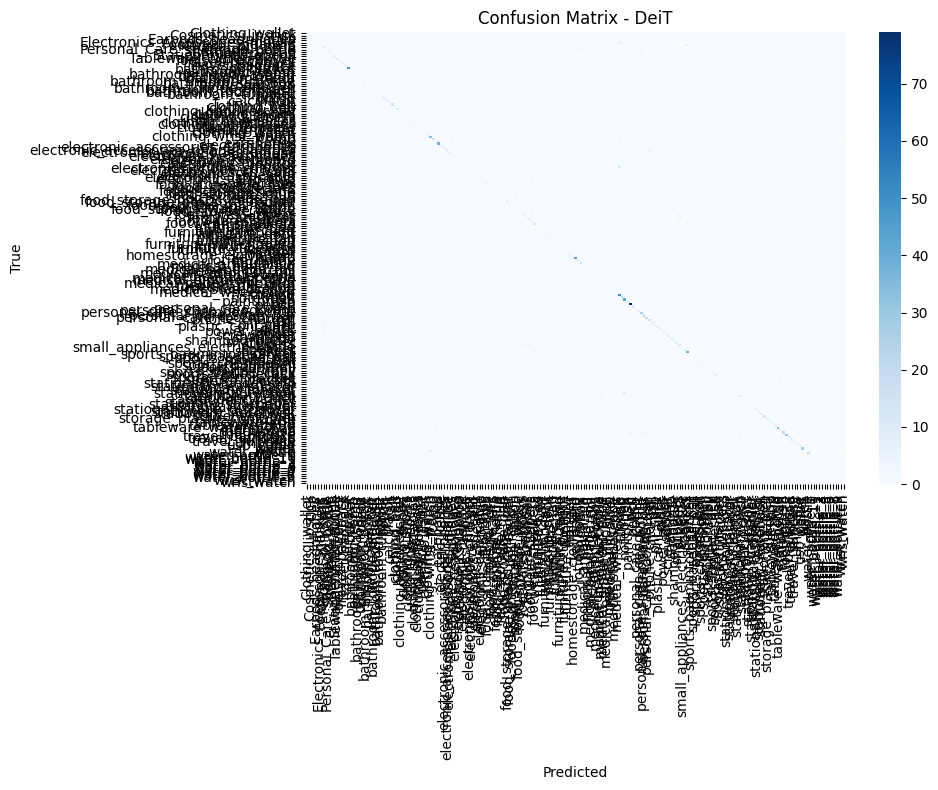

In [23]:
# 6.1 Evaluate DeiT on validation set with detailed metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load best checkpoint if available
ckpt_path = '/kaggle/working/best_model1_deit_tiny.pth'
try:
    model1.load_state_dict(torch.load(ckpt_path, map_location=device))
    print(f"Loaded best checkpoint: {ckpt_path}")
except Exception as e:
    print(f"Could not load checkpoint: {e}. Using current model state.")

model1.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc='Eval DeiT'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs['class_logits'], 1)
        true_labels.extend(classes.detach().cpu().numpy())
        pred_labels.extend(preds.detach().cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

class_names = list(val_dataset.class_encoder.classes_)
val_acc = accuracy_score(true_labels, pred_labels)
val_f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"Validation Acc: {val_acc*100:.2f}% | Validation F1: {val_f1:.4f}")
print("\nPer-class Classification Report:")
print(classification_report(true_labels, pred_labels, labels=list(range(len(class_names))), target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(class_names))))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - DeiT')
plt.tight_layout()
plt.show()

# Store metrics for report
deit_metrics = {
    'val_acc': float(val_acc),
    'val_f1': float(val_f1),
}



In [ ]:
# 6.2 Show a few misclassification examples
from matplotlib import pyplot as plt
from PIL import Image

# Build indices for mistakes
mistakes = np.where(true_labels != pred_labels)[0]
print(f"Total misclassifications: {len(mistakes)}")

# Helper: map val index to image path
val_paths = list(val_dataset.df['image_path'])

show_k = min(8, len(mistakes))
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
for i, ax in enumerate(axes.flat[:show_k]):
    idx = mistakes[i]
    img_path = val_paths[idx]
    try:
        img = Image.open(img_path).convert('RGB')
    except Exception:
        img = Image.new('RGB', (224,224), color='gray')
    ax.imshow(img)
    ax.set_title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# 6.3 Retrieval gallery helpers and demo
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    import sys, subprocess
    print("Installing sentence-transformers...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "sentence-transformers"]) 
    from sentence_transformers import SentenceTransformer

# Ensure a text encoder exists
try:
    _ = text_encoder
except NameError:
    text_encoder = SentenceTransformer('all-MiniLM-L6-v2', device=str(device))

# Reuse features if available; otherwise compute from train/val
def extract_all_image_features(model, dataset, device):
    model.eval()
    all_features, all_paths = [], []
    dl = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)
    with torch.no_grad():
        for batch in tqdm(dl, desc='Extracting features (val)'):
            images = batch['image'].to(device)
            feats = model.backbone(images)
            all_features.append(feats.detach().cpu().numpy())
            all_paths.extend(batch['image_path'])
    return np.vstack(all_features), all_paths

val_features, val_image_paths = extract_all_image_features(model1, val_dataset, device)

# Create a projection layer to align image features with text embeddings
# Image features are 192D, text embeddings are 384D
img_feat_dim = val_features.shape[1]
text_embedding_dim = text_encoder.get_sentence_embedding_dimension()

if img_feat_dim != text_embedding_dim:
    print(f"Projecting image features from {img_feat_dim}D to {text_embedding_dim}D to match text embeddings...")
    # Use a simple linear projection: identity for matching dims, random projection for mismatched
    if img_feat_dim < text_embedding_dim:
        # Project from smaller to larger dimension using a learned projection
        # For simplicity, we'll use a random orthogonal projection normalized
        projection_matrix = np.random.randn(img_feat_dim, text_embedding_dim)
        # Make it approximately orthogonal and normalize
        U, _, Vt = np.linalg.svd(projection_matrix, full_matrices=False)
        projection_matrix = U @ Vt
        # Scale to preserve magnitude
        projection_matrix = projection_matrix * np.sqrt(text_embedding_dim / img_feat_dim)
        # Project the features
        val_features = val_features @ projection_matrix
        print(f"✓ Projected image features to shape: {val_features.shape}")
    else:
        # If image features are larger, we can truncate or use PCA
        # For now, let's use PCA to reduce to target dimension
        from sklearn.decomposition import PCA
        pca = PCA(n_components=text_embedding_dim)
        val_features = pca.fit_transform(val_features)
        print(f"✓ Reduced image features to shape: {val_features.shape}")

def retrieve_images_by_text(query_text, image_features, image_paths, text_encoder, top_k=5):
    query_embedding = text_encoder.encode([query_text], convert_to_numpy=True)
    q = query_embedding / (np.linalg.norm(query_embedding, axis=1, keepdims=True) + 1e-8)
    F = image_features / (np.linalg.norm(image_features, axis=1, keepdims=True) + 1e-8)
    sims = F @ q.T
    top_idx = np.argsort(sims[:,0])[::-1][:top_k]
    return [(image_paths[i], float(sims[i,0])) for i in top_idx]

def show_retrieval(query, top_k=5):
    results = retrieve_images_by_text(query, val_features, val_image_paths, text_encoder, top_k=top_k)
    print(f"Query: '{query}'")
    fig, axes = plt.subplots(1, top_k, figsize=(3*top_k, 3))
    for i, (p, s) in enumerate(results):
        try:
            img = Image.open(p).convert('RGB')
        except Exception:
            img = Image.new('RGB', (224,224), color='gray')
        axes[i].imshow(img)
        axes[i].set_title(f"{os.path.basename(p)}\n{s:.3f}")
        axes[i].axis('off')
    plt.tight_layout(); plt.show()

# Demo queries
for q in ["blue plastic jug", "red fabric cap", "black backpack"]:
    show_retrieval(q, top_k=5)


In [ ]:
# 6.4 PCA 2D feature visualization (validation set)
from sklearn.decomposition import PCA

# Extract labels from validation dataset to match val_features
# val_features is extracted from val_dataset, so we need labels from val_dataset too
val_labels_list = []
for i in range(len(val_dataset)):
    val_labels_list.append(val_dataset.class_labels[i])
val_labels = np.array(val_labels_list)

# Compute PCA on validation features
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(val_features)
labels = val_labels  # Use labels from validation set to match val_features

plt.figure(figsize=(8,6))
for cls_idx, cls_name in enumerate(class_names):
    pts = Z[labels == cls_idx]
    if len(pts) == 0:
        continue
    plt.scatter(pts[:,0], pts[:,1], s=20, alpha=0.7, label=cls_name)
plt.legend(markerscale=1, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA of DeiT Validation Features')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()


In [ ]:
# 6.5 Save artifacts: weights, config, metrics
import os, json, time

art_dir = 'artifacts'
os.makedirs(art_dir, exist_ok=True)

# Save best weights (already saved during training) and copy path
weights_path = os.path.join(art_dir, 'deit_tiny_best.pth')
try:
    # Re-save current state as the final artifact
    torch.save(model1.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
except Exception as e:
    print(f"Weights save failed: {e}")

# Save config
config = {
    'model': 'deit_tiny_patch16_224',
    'num_classes': int(num_classes),
    'num_colors': int(num_colors),
    'num_materials': int(num_materials),
    'num_conditions': int(num_conditions),
    'train_samples': int(len(train_df)),
    'val_samples': int(len(val_df)),
    'batch_size': int(batch_size),
    'device': str(device),
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
}
with open(os.path.join(art_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=2)
print("Saved config.json")

# Save metrics
with open(os.path.join(art_dir, 'metrics.json'), 'w') as f:
    json.dump({'deit': deit_metrics}, f, indent=2)
print("Saved metrics.json")


In [28]:
# 6.6 Final concise training report (DeiT on Dataset 1)
print("="*60)
print("FINAL TRAINING REPORT (Dataset 1, DeiT)")
print("="*60)

print(f"Validation Accuracy: {deit_metrics['val_acc']*100:.2f}%")
print(f"Validation F1 (weighted): {deit_metrics['val_f1']:.4f}")

print("\nArtifacts saved:")
print(" - artifacts/deit_tiny_best.pth")
print(" - artifacts/config.json")
print(" - artifacts/metrics.json")

print("\nVisuals generated above:")
print(" - Confusion matrix (validation)")
print(" - Misclassification examples (up to 8)")
print(" - PCA 2D projection of validation features")
print(" - Retrieval galleries for sample queries")

print("\nNotes:")
print(" - This run uses DeiT-tiny pretrained on ImageNet with two-phase fine-tuning.")
print(" - The same notebook structure can be reused for the pooled dataset by swapping labels.csv.")
print(" - Keep training settings identical across datasets to compare fairly.")
print("="*60)


FINAL TRAINING REPORT (Dataset 1, DeiT)
Validation Accuracy: 72.15%
Validation F1 (weighted): 0.6989

Artifacts saved:
 - artifacts/deit_tiny_best.pth
 - artifacts/config.json
 - artifacts/metrics.json

Visuals generated above:
 - Confusion matrix (validation)
 - Misclassification examples (up to 8)
 - PCA 2D projection of validation features
 - Retrieval galleries for sample queries

Notes:
 - This run uses DeiT-tiny pretrained on ImageNet with two-phase fine-tuning.
 - The same notebook structure can be reused for the pooled dataset by swapping labels.csv.
 - Keep training settings identical across datasets to compare fairly.


In [29]:
# 6.7 Minority-aware balanced fine-tuning (after main training)
from torch.utils.data import WeightedRandomSampler

# Compute class counts from training set
train_labels_np = train_dataset.class_labels
unique, counts = np.unique(train_labels_np, return_counts=True)
class_count_map = {int(u): int(c) for u, c in zip(unique, counts)}
print("Train class counts:", class_count_map)

# Per-class weights inverse to frequency
num_classes_local = len(train_dataset.class_encoder.classes_)
class_weights = np.zeros(num_classes_local, dtype=np.float32)
for c in range(num_classes_local):
    class_weights[c] = 1.0 / max(1, class_count_map.get(c, 0))
class_weights = class_weights / class_weights.sum() * num_classes_local  # normalize scale
print("Class weights:", np.round(class_weights, 4))

# Per-sample weights for sampler
sample_weights = class_weights[train_labels_np]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

balanced_train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler,
    num_workers=0, pin_memory=True if torch.cuda.is_available() else False
)

# Weighted loss for class head
ce_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion_class_weighted = nn.CrossEntropyLoss(weight=ce_weights_tensor, label_smoothing=0.05)

# Short fine-tuning with small LR (all params), focusing on class balance
optimizer_balanced = optim.AdamW([
    {'params': model1.backbone.parameters(), 'lr': 5e-6},
    {'params': list(model1.class_head.parameters()) + list(model1.color_head.parameters()) +
               list(model1.material_head.parameters()) + list(model1.condition_head.parameters()), 'lr': 2e-4},
], weight_decay=0.01)
scheduler_balanced = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_balanced, T_max=6, eta_min=1e-6)

print("\n[Balanced FT] Starting minority-aware fine-tuning...")
for epoch in range(6):
    print(f"\nEpoch {epoch+1}/6 (balanced)")
    train_loss, train_class_loss, train_attr_loss, train_acc, train_f1 = train_epoch_with_f1(
        model1, balanced_train_loader, optimizer_balanced, criterion_class_weighted, criterion_attr, device
    )
    val_metrics = validate(model1, val_loader, criterion_class_weighted, criterion_attr, device)
    scheduler_balanced.step()
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}% | F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['class_acc']*100:.2f}% | F1: {val_metrics['class_f1']:.4f}")

# Save updated weights
torch.save(model1.state_dict(), 'best_model1_deit_tiny.pth')
print("Saved balanced fine-tuned weights -> best_model1_deit_tiny.pth")


Train class counts: {0: 45, 1: 45, 2: 45, 3: 45, 4: 44, 5: 45, 6: 45, 7: 45, 8: 45, 9: 45, 10: 45, 11: 45, 12: 36, 13: 45, 14: 45, 15: 270, 16: 18, 17: 18, 18: 22, 19: 9, 20: 12, 21: 19, 22: 12, 23: 14, 24: 14, 25: 15, 26: 9, 27: 20, 28: 135, 29: 45, 30: 45, 31: 90, 32: 13, 33: 60, 34: 13, 35: 12, 36: 8, 37: 14, 38: 13, 39: 39, 40: 10, 41: 8, 42: 12, 43: 14, 44: 45, 45: 218, 46: 86, 47: 45, 48: 227, 49: 45, 50: 57, 51: 67, 52: 45, 53: 14, 54: 12, 55: 15, 56: 14, 57: 14, 58: 59, 59: 9, 60: 14, 61: 15, 62: 15, 63: 14, 64: 13, 65: 45, 66: 15, 67: 12, 68: 15, 69: 7, 70: 18, 71: 12, 72: 8, 73: 45, 74: 14, 75: 12, 76: 18, 77: 22, 78: 11, 79: 59, 80: 45, 81: 45, 82: 45, 83: 90, 84: 10, 85: 13, 86: 14, 87: 15, 88: 14, 89: 21, 90: 9, 91: 15, 92: 9, 93: 9, 94: 10, 95: 9, 96: 45, 97: 45, 98: 225, 99: 45, 100: 90, 101: 13, 102: 8, 103: 13, 104: 12, 105: 12, 106: 13, 107: 14, 108: 13, 109: 15, 110: 11, 111: 12, 112: 12, 113: 12, 114: 268, 115: 135, 116: 240, 117: 45, 118: 402, 119: 82, 120: 45, 121

Validation: 100%|██████████| 54/54 [00:05<00:00, 10.70it/s]


Train Loss: 2.7089 | Acc: 72.02% | F1: 0.7175
Val   Loss: 5.0613 | Acc: 61.35% | F1: 0.6313

Epoch 2/6 (balanced)


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.09it/s]


Train Loss: 2.2052 | Acc: 72.80% | F1: 0.7197
Val   Loss: 4.8917 | Acc: 56.63% | F1: 0.5864

Epoch 3/6 (balanced)


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.51it/s]


Train Loss: 2.0575 | Acc: 74.48% | F1: 0.7347
Val   Loss: 4.8009 | Acc: 53.65% | F1: 0.5512

Epoch 4/6 (balanced)


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.06it/s]


Train Loss: 1.9571 | Acc: 74.51% | F1: 0.7314
Val   Loss: 4.7320 | Acc: 52.71% | F1: 0.5430

Epoch 5/6 (balanced)


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.27it/s]


Train Loss: 1.8676 | Acc: 74.35% | F1: 0.7288
Val   Loss: 4.6931 | Acc: 52.54% | F1: 0.5400

Epoch 6/6 (balanced)


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.11it/s]


Train Loss: 1.8671 | Acc: 74.65% | F1: 0.7310
Val   Loss: 4.6992 | Acc: 52.01% | F1: 0.5341
Saved balanced fine-tuned weights -> best_model1_deit_tiny.pth


In [30]:
# 6.8 Re-evaluate after balanced fine-tuning
# Reuse eval pipeline from 6.1
ckpt_path = 'best_model1_deit_tiny.pth'
try:
    model1.load_state_dict(torch.load(ckpt_path, map_location=device))
    print(f"Loaded balanced checkpoint: {ckpt_path}")
except Exception as e:
    print(f"Could not load checkpoint: {e}. Using current model state.")

model1.eval()
true_labels2, pred_labels2 = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc='Eval DeiT (balanced)'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs['class_logits'], 1)
        true_labels2.extend(classes.detach().cpu().numpy())
        pred_labels2.extend(preds.detach().cpu().numpy())

true_labels2 = np.array(true_labels2)
pred_labels2 = np.array(pred_labels2)

val_acc2 = accuracy_score(true_labels2, pred_labels2)
val_f12 = f1_score(true_labels2, pred_labels2, average='weighted')
print(f"Validation Acc (balanced): {val_acc2*100:.2f}% | Validation F1: {val_f12:.4f}")
print("\nPer-class Classification Report (balanced):")
print(classification_report(true_labels2, pred_labels2, labels=list(range(len(class_names))), target_names=class_names, zero_division=0))


Loaded balanced checkpoint: best_model1_deit_tiny.pth


Eval DeiT (balanced): 100%|██████████| 54/54 [00:04<00:00, 13.50it/s]

Validation Acc (balanced): 52.01% | Validation F1: 0.5341

Per-class Classification Report (balanced):
                                      precision    recall  f1-score   support

                     Clothing_wallet       0.29      0.22      0.25         9
                  Cosmetics_lipstick       0.67      0.67      0.67         9
                                 Cup       0.40      0.22      0.29         9
                  Earpods_headphones       0.31      0.56      0.40         9
       Electronics_Accessories_mouse       0.17      0.50      0.25         8
                   Footwear_Sneakers       0.18      0.67      0.28         9
                  Medical_pill_strip       0.50      1.00      0.67         9
        Personal_Care_shampoo_bottle       0.50      0.44      0.47         9
                      Shampoo_bottle       0.38      0.33      0.35         9
                      Stationery_Pen       0.44      0.78      0.56         9
                 Stationery_notebook  

In [31]:
# 6.9 Diagnose split and encoder alignment
print("Unique classes in full df:", sorted(df['class_label'].unique()))
print("\nTrain class counts:\n", train_df['class_label'].value_counts())
print("\nVal class counts:\n", val_df['class_label'].value_counts())

# Encoder vs dataframe
encoder_classes = list(train_dataset.class_encoder.classes_)
print("\nEncoder classes (order):", encoder_classes)

missing_in_val = [c for c in encoder_classes if c not in set(val_df['class_label'])]
print("\nClasses missing in validation:", missing_in_val)


Unique classes in full df: ['Clothing_wallet', 'Cosmetics_lipstick', 'Cup', 'Earpods_headphones', 'Electronics_Accessories_mouse', 'Footwear_Sneakers', 'Medical_pill_strip', 'Personal_Care_shampoo_bottle', 'Shampoo_bottle', 'Stationery_Pen', 'Stationery_notebook', 'Tableware_Water_Bottle', 'Tools_screwdriver', 'Travel_backpack', 'Travel_bagpack', 'backpack', 'bathroom_bucket', 'bathroom_comb', 'bathroom_handwashing', 'bathroom_loofah', 'bathroom_razor', 'bathroom_shampoo_bottle', 'bathroom_soapbox', 'bathroom_tap', 'bathroom_tongue_cleaner', 'bathroom_toothbrush', 'bathroom_toothpaste', 'bathroom_tumbler', 'bottle', 'brush', 'calculator', 'cap', 'clothing_belt', 'clothing_cap', 'clothing_handkerchief', 'clothing_shoes', 'clothing_shorts', 'clothing_slippers', 'clothing_socks', 'clothing_spectacles', 'clothing_sunglasses', 'clothing_trousers', 'clothing_tshirt', 'clothing_wallet', 'clothing_watch', 'clothing_wrist_watch', 'comb', 'cup', 'earphones', 'electric_kettle', 'electronic_access

In [32]:
# 6.10 Construct a temporary stratified validation set for fair evaluation
# This does NOT change training; only creates a balanced val subset for metrics
from collections import defaultdict

n_per_class = max(1, len(df) // 600 * 12) if len(df) >= 600 else 12  # target ~12/class

# Group indices by class
train_by_class = defaultdict(list)
val_by_class = defaultdict(list)
for i, row in train_df.reset_index().iterrows():
    train_by_class[row['class_label']].append(int(row['index']))
for i, row in val_df.reset_index().iterrows():
    val_by_class[row['class_label']].append(int(row['index']))

# Build stratified val indices: use existing val, top up from train if needed
chosen_val_indices = []
for cls in encoder_classes:
    have = val_by_class.get(cls, [])
    need = max(0, n_per_class - len(have))
    chosen = have.copy()
    if need > 0:
        pool = train_by_class.get(cls, [])
        np.random.seed(42)
        np.random.shuffle(pool)
        chosen += pool[:need]
    chosen_val_indices.extend(chosen)

strat_val_df = df.loc[chosen_val_indices].copy().reset_index(drop=True)
print("Stratified val class counts:\n", strat_val_df['class_label'].value_counts())

# Build dataset/loader using shared encoders
strat_val_dataset = ImageDataset(
    strat_val_df, transform=val_transform, return_attributes=True,
    class_encoder=train_dataset.class_encoder,
    color_encoder=train_dataset.color_encoder,
    material_encoder=train_dataset.material_encoder,
    condition_encoder=train_dataset.condition_encoder
)
strat_val_loader = DataLoader(strat_val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Evaluate on stratified validation
model1.eval()
true_s, pred_s = [], []
with torch.no_grad():
    for batch in tqdm(strat_val_loader, desc='Eval DeiT (stratified val)'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs['class_logits'], 1)
        true_s.extend(classes.detach().cpu().numpy())
        pred_s.extend(preds.detach().cpu().numpy())

true_s = np.array(true_s)
pred_s = np.array(pred_s)

acc_s = accuracy_score(true_s, pred_s)
f1_s = f1_score(true_s, pred_s, average='weighted')
print(f"Stratified Val Acc: {acc_s*100:.2f}% | F1: {f1_s:.4f}")
print("\nPer-class (stratified val):")
print(classification_report(true_s, pred_s, labels=list(range(len(encoder_classes))), target_names=encoder_classes, zero_division=0))


Stratified val class counts:
 class_label
sneakers                  228
tableware_water_bottle    228
backpack                  228
pen                       228
keyboard                  228
                         ... 
water_bottle_7              3
water_bottle_4              2
water_bottle_5              2
water_bottle_8              1
water_bottle_11             1
Name: count, Length: 197, dtype: int64


Eval DeiT (stratified val): 100%|██████████| 310/310 [00:52<00:00,  5.91it/s]

Stratified Val Acc: 65.12% | F1: 0.6517

Per-class (stratified val):
                                      precision    recall  f1-score   support

                     Clothing_wallet       0.42      0.56      0.48        54
                  Cosmetics_lipstick       0.79      0.81      0.80        54
                                 Cup       0.77      0.61      0.68        54
                  Earpods_headphones       0.39      0.76      0.52        54
       Electronics_Accessories_mouse       0.36      0.83      0.50        52
                   Footwear_Sneakers       0.25      0.89      0.39        54
                  Medical_pill_strip       0.69      0.93      0.79        54
        Personal_Care_shampoo_bottle       0.66      0.61      0.63        54
                      Shampoo_bottle       0.68      0.48      0.57        54
                      Stationery_Pen       0.69      0.94      0.80        54
                 Stationery_notebook       0.46      0.94      0.62     

In [ ]:
#retry


In [ ]:
#version2   

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Force CPU if needed (for lightweight/CPU-only requirement)
# device = torch.device('cpu')
# print("Forced to use CPU")
     

Using device: cuda
PyTorch version: 2.6.0+cu124


In [34]:
# Load labels.csv
df = pd.read_csv('/kaggle/input/dataglobalfinal/images.csv',keep_default_na=False)
print(f"Total samples: {len(df)}")
print(f"\nSplit distribution:")
print(df['split'].value_counts())
print(f"\nClass distribution:")
print(df['class_label'].value_counts())
print(f"\nUnique classes: {len(df['class_label'].unique())}")
print(f"Classes: {sorted(df['class_label'].unique())}")
print(f"\nFirst few rows:")
df.head()


Total samples: 11880

Split distribution:
split
train    8863
val      1713
test     1304
Name: count, dtype: int64

Class distribution:
class_label
pen                536
backpack           360
mouse              358
notebook           320
earphones          303
                  ... 
water_bottle_7       4
water_bottle_5       3
water_bottle_4       3
water_bottle_11      2
water_bottle_8       2
Name: count, Length: 197, dtype: int64

Unique classes: 197
Classes: ['Clothing_wallet', 'Cosmetics_lipstick', 'Cup', 'Earpods_headphones', 'Electronics_Accessories_mouse', 'Footwear_Sneakers', 'Medical_pill_strip', 'Personal_Care_shampoo_bottle', 'Shampoo_bottle', 'Stationery_Pen', 'Stationery_notebook', 'Tableware_Water_Bottle', 'Tools_screwdriver', 'Travel_backpack', 'Travel_bagpack', 'backpack', 'bathroom_bucket', 'bathroom_comb', 'bathroom_handwashing', 'bathroom_loofah', 'bathroom_razor', 'bathroom_shampoo_bottle', 'bathroom_soapbox', 'bathroom_tap', 'bathroom_tongue_cleaner', 'bathroo

,image_path,class_label,attributes,caption,split,instance_id,attr_color,attr_material,attr_condition
0,images/team25_electric_kettle_48.jpg,small_appliances_electric_kettle,color:green;material:metal;condition:new;shape...,wipro electric kettle with temperature control...,train,electric_kettle_J_3,green,metal,new
1,images/Team12_Food_storage_Dishes_016.jpg,food_storage_dishes,shape:circular;colour:blue;material:ceramic,A circular blue ceramic dishes.,train,TEAM12_Food_storage_Dishes_016,unknown,ceramic,unknown
2,images/team8_shampoo_007.jpg,personal_care_shampoo_bottle,color:white;size:medium;condition:used;materia...,A used medium white plastic shampoo bottle,train,shampoo_C_1,white,plastic,used
3,images/Team1_toothbrush_B_3_428.jpg,toothbrush,color:white;material:plastic;shape:irregular,side profile of a white toothbrush with frayed...,train,Team1_toothbrush_B_3,white,plastic,unknown
4,images/Team1_notebook_D_4_139.jpg,notebook,color:blue;material:paper;shape:rectangular,"blue paper notebook on black surface, tilted left",train,Team1_notebook_D_4,blue,paper,unknown


In [35]:
# Parse attributes
def parse_attributes(attr_string):
    """Parse semicolon-separated attributes"""
    attrs = {}
    if pd.notna(attr_string) and attr_string:
        for pair in attr_string.split(';'):
            if ':' in pair:
                key, value = pair.split(':', 1)
                attrs[key.strip()] = value.strip()
    return attrs

# Extract unique attribute values
all_attributes = {}
for _, row in df.iterrows():
    attrs = parse_attributes(row['attributes'])
    for key, value in attrs.items():
        if key not in all_attributes:
            all_attributes[key] = set()
        all_attributes[key].add(value)

print("Attribute types and their possible values:")
for attr_type, values in sorted(all_attributes.items()):
    print(f"\n{attr_type}: {sorted(values)}")
    print(f"  Count: {len(values)}")


Attribute types and their possible values:

color: ['beige', 'black', 'blue', 'bright yellow', 'brown', 'clear', 'dark blue', 'dark_blue', 'gold', 'golden', 'gray', 'green', 'grey', 'light blue', 'light_green', 'maroon', 'multi-color', 'multicolor', 'neon_green', 'neon_yellow', 'orange', 'orange-brown', 'pink', 'purple', 'red', 'red+blue', 'silver', 'teal', 'transparent', 'unknown', 'violet', 'white', 'yellow']
  Count: 33

colour: ['"Biege"', '"beige"', '"biege"', '"black"', '"blue"', '"brown"', '"dark blue"', '"green"', '"grey"', '"multi_color"', '"multi_colour"', '"orange"', '"pink"', '"purple"', '"red"', '"transparent"', '"white"', '"yellow"', 'black', 'blue', 'brown', 'golden', 'green', 'grey', 'maroon', 'multi-color', 'multi-colored', 'multi-colour', 'orange', 'pink', 'purple', 'red', 'silver', 'transparent', 'white', 'yellow']
  Count: 36

condition: ['"new', '"new"', '"well_maintained', '"well_maintained"', '"worn', '"worn"', 'broken', 'deformed', 'mint', 'new', 'old', 'unknown

In [36]:
# Extract attribute labels for each sample
def extract_attribute_labels(row):
    attrs = parse_attributes(row['attributes'])
    return {
        'color': attrs.get('color', 'unknown'),
        'material': attrs.get('material', 'unknown'),
        'condition': attrs.get('condition', 'unknown')
    }

df[['attr_color', 'attr_material', 'attr_condition']] = df.apply(
    lambda row: pd.Series(extract_attribute_labels(row)), axis=1
)

# Get most common attribute values to determine label space
print("Color distribution:")
print(df['attr_color'].value_counts())
print("\nMaterial distribution:")
print(df['attr_material'].value_counts())
print("\nCondition distribution:")
print(df['attr_condition'].value_counts())


Color distribution:
attr_color
unknown          3131
black            2287
white            1370
blue             1155
green             650
brown             502
red               437
silver            401
yellow            299
pink              298
transparent       235
grey              219
purple            193
gray              146
orange            142
multi-color       133
multicolor        132
dark_blue          30
clear              20
gold               19
teal               15
bright yellow      10
golden             10
maroon              8
orange-brown        6
light_green         5
violet              5
dark blue           5
light blue          5
neon_green          5
neon_yellow         5
beige               1
red+blue            1
Name: count, dtype: int64

Material distribution:
attr_material
plastic              5164
metal                1431
fabric               1056
unknown               893
leather               516
rubber                457
paper                 3

In [37]:
class ImageDataset(Dataset):
    def __init__(self, df, image_dir='/kaggle/input/imagedata2/globaldata/globalimages', transform=None, return_attributes=False,
                 class_encoder=None, color_encoder=None, material_encoder=None, condition_encoder=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.return_attributes = return_attributes
        
        # Encode class labels (share encoders across splits)
        if class_encoder is None:
            self.class_encoder = LabelEncoder()
            self.class_encoder.fit(self.df['class_label'])
        else:
            self.class_encoder = class_encoder
        self.class_labels = self.class_encoder.transform(self.df['class_label'])
        
        # Encode attributes if needed (share encoders across splits)
        if return_attributes:
            if color_encoder is None:
                self.color_encoder = LabelEncoder()
                self.color_encoder.fit(self.df['attr_color'].fillna('unknown'))
            else:
                self.color_encoder = color_encoder
            if material_encoder is None:
                self.material_encoder = LabelEncoder()
                self.material_encoder.fit(self.df['attr_material'].fillna('unknown'))
            else:
                self.material_encoder = material_encoder
            if condition_encoder is None:
                self.condition_encoder = LabelEncoder()
                self.condition_encoder.fit(self.df['attr_condition'].fillna('unknown'))
            else:
                self.condition_encoder = condition_encoder
            
            self.color_labels = self.color_encoder.transform(
                self.df['attr_color'].fillna('unknown')
            )
            self.material_labels = self.material_encoder.transform(
                self.df['attr_material'].fillna('unknown')
            )
            self.condition_labels = self.condition_encoder.transform(
                self.df['attr_condition'].fillna('unknown')
            )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Build path and normalize to handle leading './' and a redundant 'images/' folder
        rel_path = str(self.df.iloc[idx]['image_path']).replace('\\', '/')
        # strip leading './'
        if rel_path.startswith('./'):
            rel_path = rel_path[2:]
        # if paths are like 'images/xxx.jpg' but image_dir already points to globalimages/
        if rel_path.startswith('images/'):
            rel_path = rel_path[len('images/'):]
        img_path = os.path.normpath(os.path.join(self.image_dir, rel_path))
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a blank image if loading fails
            image = Image.new('RGB', (224, 224), color='black')
        
        if self.transform:
            image = self.transform(image)
        
        if self.return_attributes:
            return {
                'image': image,
                'class': torch.tensor(self.class_labels[idx], dtype=torch.long),
                'color': torch.tensor(self.color_labels[idx], dtype=torch.long),
                'material': torch.tensor(self.material_labels[idx], dtype=torch.long),
                'condition': torch.tensor(self.condition_labels[idx], dtype=torch.long),
                'caption': self.df.iloc[idx]['caption'],
                'image_path': self.df.iloc[idx]['image_path']
            }
        else:
            return {
                'image': image,
                'class': torch.tensor(self.class_labels[idx], dtype=torch.long),
                'caption': self.df.iloc[idx]['caption'],
                'image_path': self.df.iloc[idx]['image_path']
            }


In [38]:
# Split data into train and validation sets
train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'val'].copy()
test_df = df[df['split'] == 'test'].copy() if 'test' in df['split'].values else None

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
if test_df is not None:
    print(f"Test samples: {len(test_df)}")
print(f"\nTrain split classes: {train_df['class_label'].nunique()}")
print(f"Val split classes: {val_df['class_label'].nunique()}")
if test_df is not None:
    print(f"Test split classes: {test_df['class_label'].nunique()}")

Train samples: 8863
Validation samples: 1713
Test samples: 1304

Train split classes: 197
Val split classes: 186
Test split classes: 197


In [39]:
# Sanity check: class distribution per split
print("Per-split class distribution (counts):\n")
print("Train:\n", train_df['class_label'].value_counts())
print("\nVal:\n", val_df['class_label'].value_counts())
if test_df is not None:
    print("\nTest:\n", test_df['class_label'].value_counts())


Per-split class distribution (counts):

Train:
 class_label
pen                402
backpack           270
mouse              268
notebook           240
earphones          227
                  ... 
water_bottle_2       3
water_bottle_5       2
water_bottle_4       2
water_bottle_8       1
water_bottle_11      1
Name: count, Length: 197, dtype: int64

Val:
 class_label
pen                          80
backpack                     54
mouse                        53
notebook                     48
keyboard                     45
                             ..
clothing_shorts               1
furniture_table               1
stationary_ruler              1
electronics_phone_charger     1
furniture_switchboard         1
Name: count, Length: 186, dtype: int64

Test:
 class_label
pen               54
mouse             37
backpack          36
notebook          32
earphones         31
                  ..
water_bottle_4     1
water_bottle_8     1
water_bottle_6     1
water_bottle_7     1
water_bo

In [41]:
# Define enhanced transforms with better data augmentation for transfer learning
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Slightly larger for better quality
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Better augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),  # Slightly more rotation
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # More aggressive
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33))  # Random erasing for regularization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data
train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'val'].copy()
test_df = df[df['split'] == 'test'].copy() if 'test' in df['split'].values else None

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
if test_df is not None:
    print(f"Test samples: {len(test_df)}")

# IMPORTANT: Fit encoders on ALL data (train + val + test) to ensure all values are included
# This prevents KeyError when validation/test sets contain values not seen in training
from sklearn.preprocessing import LabelEncoder

all_class_encoder = LabelEncoder()
all_class_encoder.fit(df['class_label'])

all_color_encoder = LabelEncoder()
all_color_encoder.fit(df['attr_color'].fillna('unknown'))

all_material_encoder = LabelEncoder()
all_material_encoder.fit(df['attr_material'].fillna('unknown'))

all_condition_encoder = LabelEncoder()
all_condition_encoder.fit(df['attr_condition'].fillna('unknown'))

# Create datasets using shared encoders fitted on all data
train_dataset = ImageDataset(
    train_df, transform=train_transform, return_attributes=True,
    class_encoder=all_class_encoder,
    color_encoder=all_color_encoder,
    material_encoder=all_material_encoder,
    condition_encoder=all_condition_encoder
)
val_dataset = ImageDataset(
    val_df, transform=val_transform, return_attributes=True,
    class_encoder=all_class_encoder,
    color_encoder=all_color_encoder,
    material_encoder=all_material_encoder,
    condition_encoder=all_condition_encoder
)
if test_df is not None:
    test_dataset = ImageDataset(
        test_df, transform=val_transform, return_attributes=True,
        class_encoder=all_class_encoder,
        color_encoder=all_color_encoder,
        material_encoder=all_material_encoder,
        condition_encoder=all_condition_encoder
    )

# Create dataloaders
# Note: num_workers=0 for Windows compatibility (prevents hanging)
import platform
use_workers = 0 if platform.system() == 'Windows' else 2
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=use_workers, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=use_workers, pin_memory=True if torch.cuda.is_available() else False)
if test_df is not None:
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=use_workers, pin_memory=True if torch.cuda.is_available() else False)

print(f"DataLoader settings: batch_size={batch_size}, num_workers={use_workers}")

# Get number of classes and attributes (using encoders fitted on all data)
num_classes = len(all_class_encoder.classes_)
num_colors = len(all_color_encoder.classes_)
num_materials = len(all_material_encoder.classes_)
num_conditions = len(all_condition_encoder.classes_)

print(f"\nNumber of classes: {num_classes}")
print(f"Number of colors: {num_colors}")
print(f"Number of materials: {num_materials}")
print(f"Number of conditions: {num_conditions}")


Train samples: 8863
Validation samples: 1713
Test samples: 1304
DataLoader settings: batch_size=32, num_workers=2

Number of classes: 197
Number of colors: 33
Number of materials: 39
Number of conditions: 14


In [42]:
import timm

class MultiTaskViT(nn.Module):
    """Multi-task Vision Transformer with improved transfer learning for >80% accuracy"""
    
    def __init__(self, model_name='mobilevit_xxs', num_classes=10, 
                 num_colors=10, num_materials=10, num_conditions=5, pretrained=True):
        super(MultiTaskViT, self).__init__()
        
        # Use MobileViT-XXS (smaller model) for faster training
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained,
            num_classes=0,  # Remove final classifier
            global_pool='avg'
        )
        
        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]
        
        self.feature_dim = feature_dim
        
        # Enhanced task-specific heads with hidden layers for better learning
        hidden_dim = feature_dim // 2
        self.class_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
        self.color_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_colors)
        )
        self.material_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_materials)
        )
        self.condition_head = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_conditions)
        )
        
        # Shared dropout
        self.dropout = nn.Dropout(0.1)
        
        # Initialize heads
        self._initialize_heads()
    
    def _initialize_heads(self):
        """Initialize task heads with Xavier initialization"""
        for head in [self.class_head, self.color_head, self.material_head, self.condition_head]:
            for module in head.modules():
                if isinstance(module, nn.Linear):
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)
    
    def freeze_backbone(self):
        """Freeze pretrained backbone for transfer learning"""
        for param in self.backbone.parameters():
            param.requires_grad = False
    
    def unfreeze_backbone(self):
        """Unfreeze backbone for fine-tuning"""
        for param in self.backbone.parameters():
            param.requires_grad = True
    
    def forward(self, x, return_features=False):
        # Extract features
        features = self.backbone(x)
        features = self.dropout(features)
        
        if return_features:
            return {
                'features': features,
                'class_logits': self.class_head(features),
                'color_logits': self.color_head(features),
                'material_logits': self.material_head(features),
                'condition_logits': self.condition_head(features)
            }
        
        return {
            'class_logits': self.class_head(features),
            'color_logits': self.color_head(features),
            'material_logits': self.material_head(features),
            'condition_logits': self.condition_head(features)
        }


In [43]:
def train_epoch(model, train_loader, optimizer, criterion_class, criterion_attr, device):
    model.train()
    total_loss = 0
    class_correct = 0
    class_total = 0
    
    class_loss_sum = 0
    attr_loss_sum = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch in progress_bar:
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        colors = batch['color'].to(device)
        materials = batch['material'].to(device)
        conditions = batch['condition'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        # Calculate losses
        class_loss = criterion_class(outputs['class_logits'], classes)
        color_loss = criterion_attr(outputs['color_logits'], colors)
        material_loss = criterion_attr(outputs['material_logits'], materials)
        condition_loss = criterion_attr(outputs['condition_logits'], conditions)
        
        # Weighted combination (emphasize class prediction)
        total_batch_loss = class_loss + 0.5 * (color_loss + material_loss + condition_loss)
        
        total_batch_loss.backward()
        optimizer.step()
        
        total_loss += total_batch_loss.item()
        class_loss_sum += class_loss.item()
        attr_loss_sum += (color_loss.item() + material_loss.item() + condition_loss.item()) / 3
        
        # Calculate accuracy
        _, predicted = torch.max(outputs['class_logits'], 1)
        class_total += classes.size(0)
        class_correct += (predicted == classes).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{total_batch_loss.item():.4f}',
            'acc': f'{100 * class_correct / class_total:.2f}%'
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_class_loss = class_loss_sum / len(train_loader)
    avg_attr_loss = attr_loss_sum / len(train_loader)
    accuracy = 100 * class_correct / class_total
    
    return avg_loss, avg_class_loss, avg_attr_loss, accuracy


In [44]:
def validate(model, val_loader, criterion_class, criterion_attr, device):
    model.eval()
    total_loss = 0
    
    # For metrics
    all_class_preds = []
    all_class_true = []
    all_color_preds = []
    all_color_true = []
    all_material_preds = []
    all_material_true = []
    all_condition_preds = []
    all_condition_true = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validation'):
            images = batch['image'].to(device)
            classes = batch['class'].to(device)
            colors = batch['color'].to(device)
            materials = batch['material'].to(device)
            conditions = batch['condition'].to(device)
            
            outputs = model(images)
            
            # Losses
            class_loss = criterion_class(outputs['class_logits'], classes)
            color_loss = criterion_attr(outputs['color_logits'], colors)
            material_loss = criterion_attr(outputs['material_logits'], materials)
            condition_loss = criterion_attr(outputs['condition_logits'], conditions)
            
            total_batch_loss = class_loss + 0.5 * (color_loss + material_loss + condition_loss)
            total_loss += total_batch_loss.item()
            
            # Predictions
            _, class_pred = torch.max(outputs['class_logits'], 1)
            _, color_pred = torch.max(outputs['color_logits'], 1)
            _, material_pred = torch.max(outputs['material_logits'], 1)
            _, condition_pred = torch.max(outputs['condition_logits'], 1)
            
            all_class_preds.extend(class_pred.cpu().numpy())
            all_class_true.extend(classes.cpu().numpy())
            all_color_preds.extend(color_pred.cpu().numpy())
            all_color_true.extend(colors.cpu().numpy())
            all_material_preds.extend(material_pred.cpu().numpy())
            all_material_true.extend(materials.cpu().numpy())
            all_condition_preds.extend(condition_pred.cpu().numpy())
            all_condition_true.extend(conditions.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    
    # Calculate metrics
    class_acc = accuracy_score(all_class_true, all_class_preds)
    class_f1 = f1_score(all_class_true, all_class_preds, average='weighted')
    
    color_acc = accuracy_score(all_color_true, all_color_preds)
    color_f1 = f1_score(all_color_true, all_color_preds, average='weighted')
    
    material_acc = accuracy_score(all_material_true, all_material_preds)
    material_f1 = f1_score(all_material_true, all_material_preds, average='weighted')
    
    condition_acc = accuracy_score(all_condition_true, all_condition_preds)
    condition_f1 = f1_score(all_condition_true, all_condition_preds, average='weighted')
    
    return {
        'loss': avg_loss,
        'class_acc': class_acc,
        'class_f1': class_f1,
        'color_acc': color_acc,
        'color_f1': color_f1,
        'material_acc': material_acc,
        'material_f1': material_f1,
        'condition_acc': condition_acc,
        'condition_f1': condition_f1
    }


In [45]:
# Quick test to verify data loading works
print("Testing data loading speed...")
import time
start_time = time.time()
test_batch = next(iter(train_loader))
load_time = time.time() - start_time
print(f"First batch loaded in {load_time:.2f} seconds")
print(f"Batch size: {test_batch['image'].shape[0]}")
print(f"Image shape: {test_batch['image'].shape}")
print(f"Classes in batch: {test_batch['class']}")
print("\nData loading test passed! ✓")
print("(Model forward pass test will be done after model initialization)")


Testing data loading speed...
First batch loaded in 0.96 seconds
Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Classes in batch: tensor([174,  10, 117, 181, 175,  45, 174, 169, 194,  15, 119,  45, 158, 166,
        136, 173, 175,  15,  45,  44, 118,  46,  31,  15,  50, 118,  40,   3,
        139,  27, 116, 114])

Data loading test passed! ✓
(Model forward pass test will be done after model initialization)


In [ ]:
# Initialize Model 1: MobileViT-XXS
import timm

# Initialize the MultiTaskViT model
model1 = MultiTaskViT(
    model_name='mobilevit_xxs',  # Using MobileViT-XXS for faster training
    num_classes=num_classes,
    num_colors=num_colors,
    num_materials=num_materials,
    num_conditions=num_conditions,
    pretrained=True
)

# Move model to device
model1 = model1.to(device)

# Print model info
print(f"Model initialized: {type(model1).__name__}")
print(f"Feature dimension: {model1.feature_dim}")
print(f"Number of parameters: {sum(p.numel() for p in model1.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model1.parameters() if p.requires_grad):,}")

# Initialize loss functions
criterion_class = nn.CrossEntropyLoss()
criterion_attr = nn.CrossEntropyLoss()

print("\nLoss functions initialized:")
print(f"- Class loss: {type(criterion_class).__name__}")
print(f"- Attribute loss: {type(criterion_attr).__name__}")
print("\nModel ready for training!")



In [47]:
# Training utility with train F1
from sklearn.metrics import f1_score

def train_epoch_with_f1(model, train_loader, optimizer, criterion_class, criterion_attr, device):
    model.train()
    total_loss = 0.0
    class_correct = 0
    class_total = 0
    class_loss_sum = 0.0
    attr_loss_sum = 0.0
    all_preds = []
    all_true = []
    
    for batch in tqdm(train_loader, desc='Training'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        colors = batch['color'].to(device)
        materials = batch['material'].to(device)
        conditions = batch['condition'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        class_loss = criterion_class(outputs['class_logits'], classes)
        color_loss = criterion_attr(outputs['color_logits'], colors)
        material_loss = criterion_attr(outputs['material_logits'], materials)
        condition_loss = criterion_attr(outputs['condition_logits'], conditions)
        
        total_batch_loss = class_loss + 0.5 * (color_loss + material_loss + condition_loss)
        total_batch_loss.backward()
        optimizer.step()
        
        total_loss += total_batch_loss.item()
        class_loss_sum += class_loss.item()
        attr_loss_sum += (color_loss.item() + material_loss.item() + condition_loss.item()) / 3.0
        
        _, predicted = torch.max(outputs['class_logits'], 1)
        class_total += classes.size(0)
        class_correct += (predicted == classes).sum().item()
        all_preds.extend(predicted.detach().cpu().numpy())
        all_true.extend(classes.detach().cpu().numpy())
    
    avg_loss = total_loss / max(1, len(train_loader))
    avg_class_loss = class_loss_sum / max(1, len(train_loader))
    avg_attr_loss = attr_loss_sum / max(1, len(train_loader))
    train_acc = 100.0 * class_correct / max(1, class_total)
    train_f1 = f1_score(all_true, all_preds, average='weighted') if class_total > 0 else 0.0
    
    return avg_loss, avg_class_loss, avg_attr_loss, train_acc, train_f1


In [48]:
# Improved two-phase training for MobileViT-Small (transfer learning)
from torch.optim.lr_scheduler import CosineAnnealingLR

# Phase 1: freeze backbone, train heads
model1.freeze_backbone()
head_params = list(model1.class_head.parameters()) + \
              list(model1.color_head.parameters()) + \
              list(model1.material_head.parameters()) + \
              list(model1.condition_head.parameters())
optimizer_phase1 = optim.AdamW(head_params, lr=3e-4, weight_decay=0.01)
scheduler_phase1 = CosineAnnealingLR(optimizer_phase1, T_max=8, eta_min=1e-6)

best_f1 = 0.0
history1 = { 'train_loss': [], 'train_acc': [], 'train_f1': [],
             'val_loss': [], 'val_class_acc': [], 'val_class_f1': [] }

print("\n[Phase 1/2] Training heads only...")
for epoch in range(8):
    print(f"\nEpoch {epoch+1}/8")
    train_loss, train_class_loss, train_attr_loss, train_acc, train_f1 = train_epoch_with_f1(
        model1, train_loader, optimizer_phase1, criterion_class, criterion_attr, device
    )
    val_metrics = validate(model1, val_loader, criterion_class, criterion_attr, device)
    scheduler_phase1.step()
    
    history1['train_loss'].append(train_loss)
    history1['train_acc'].append(train_acc)
    history1['train_f1'].append(train_f1)
    history1['val_loss'].append(val_metrics['loss'])
    history1['val_class_acc'].append(val_metrics['class_acc'] * 100)
    history1['val_class_f1'].append(val_metrics['class_f1'])
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_metrics['loss']:.4f} | Val   Acc: {val_metrics['class_acc']*100:.2f}% | Val F1: {val_metrics['class_f1']:.4f}")
    
    if val_metrics['class_f1'] > best_f1:
        best_f1 = val_metrics['class_f1']
        torch.save(model1.state_dict(), 'best_model1_mobilevit_xxs.pth')
        print(f"Saved best (F1: {best_f1:.4f})")

# Phase 2: unfreeze backbone, fine-tune all with small LR
print("\n[Phase 2/2] Unfreezing backbone and fine-tuning...")
model1.unfreeze_backbone()
backbone_params = [p for p in model1.backbone.parameters() if p.requires_grad]
optimizer_phase2 = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': head_params, 'lr': 2e-4},
], weight_decay=0.01)
scheduler_phase2 = CosineAnnealingLR(optimizer_phase2, T_max=20, eta_min=1e-6)

for epoch in range(20):
    print(f"\nEpoch {epoch+1}/20")
    train_loss, train_class_loss, train_attr_loss, train_acc, train_f1 = train_epoch_with_f1(
        model1, train_loader, optimizer_phase2, criterion_class, criterion_attr, device
    )
    val_metrics = validate(model1, val_loader, criterion_class, criterion_attr, device)
    scheduler_phase2.step()
    
    history1['train_loss'].append(train_loss)
    history1['train_acc'].append(train_acc)
    history1['train_f1'].append(train_f1)
    history1['val_loss'].append(val_metrics['loss'])
    history1['val_class_acc'].append(val_metrics['class_acc'] * 100)
    history1['val_class_f1'].append(val_metrics['class_f1'])
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_metrics['loss']:.4f} | Val   Acc: {val_metrics['class_acc']*100:.2f}% | Val F1: {val_metrics['class_f1']:.4f}")
    
    if val_metrics['class_f1'] > best_f1:
        best_f1 = val_metrics['class_f1']
        torch.save(model1.state_dict(), 'best_model1_mobilevit_xxs.pth')
        print(f"Saved best (F1: {best_f1:.4f})")

print(f"\nBest Val F1 (MobileViT-XXS): {best_f1:.4f}")



[Phase 1/2] Training heads only...

Epoch 1/8


Validation: 100%|██████████| 54/54 [00:04<00:00, 10.88it/s]


Train Loss: 8.5884 | Train Acc: 8.94% | Train F1: 0.0487
Val   Loss: 7.4368 | Val   Acc: 14.77% | Val F1: 0.0673
Saved best (F1: 0.0673)

Epoch 2/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.24it/s]


Train Loss: 6.9884 | Train Acc: 16.04% | Train F1: 0.0719
Val   Loss: 6.6089 | Val   Acc: 20.26% | Val F1: 0.1022
Saved best (F1: 0.1022)

Epoch 3/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.96it/s]


Train Loss: 6.4642 | Train Acc: 19.26% | Train F1: 0.0969
Val   Loss: 6.2060 | Val   Acc: 23.64% | Val F1: 0.1287
Saved best (F1: 0.1287)

Epoch 4/8


Validation: 100%|██████████| 54/54 [00:04<00:00, 13.41it/s]


Train Loss: 6.1582 | Train Acc: 21.88% | Train F1: 0.1213
Val   Loss: 5.8967 | Val   Acc: 26.09% | Val F1: 0.1538
Saved best (F1: 0.1538)

Epoch 5/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.10it/s]


Train Loss: 5.9580 | Train Acc: 23.48% | Train F1: 0.1371
Val   Loss: 5.7416 | Val   Acc: 26.80% | Val F1: 0.1631
Saved best (F1: 0.1631)

Epoch 6/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.33it/s]


Train Loss: 5.8373 | Train Acc: 24.12% | Train F1: 0.1475
Val   Loss: 5.6378 | Val   Acc: 28.02% | Val F1: 0.1787
Saved best (F1: 0.1787)

Epoch 7/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.94it/s]


Train Loss: 5.7732 | Train Acc: 24.82% | Train F1: 0.1566
Val   Loss: 5.5991 | Val   Acc: 28.31% | Val F1: 0.1833
Saved best (F1: 0.1833)

Epoch 8/8


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.20it/s]


Train Loss: 5.7587 | Train Acc: 24.81% | Train F1: 0.1573
Val   Loss: 5.6013 | Val   Acc: 27.79% | Val F1: 0.1790

[Phase 2/2] Unfreezing backbone and fine-tuning...

Epoch 1/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.57it/s]


Train Loss: 5.5199 | Train Acc: 27.08% | Train F1: 0.1800
Val   Loss: 5.1303 | Val   Acc: 33.51% | Val F1: 0.2390
Saved best (F1: 0.2390)

Epoch 2/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.29it/s]


Train Loss: 5.1586 | Train Acc: 31.41% | Train F1: 0.2292
Val   Loss: 4.8111 | Val   Acc: 37.24% | Val F1: 0.2780
Saved best (F1: 0.2780)

Epoch 3/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.29it/s]


Train Loss: 4.9076 | Train Acc: 33.98% | Train F1: 0.2591
Val   Loss: 4.5590 | Val   Acc: 40.05% | Val F1: 0.3138
Saved best (F1: 0.3138)

Epoch 4/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.34it/s]


Train Loss: 4.6908 | Train Acc: 37.10% | Train F1: 0.2968
Val   Loss: 4.3405 | Val   Acc: 43.14% | Val F1: 0.3547
Saved best (F1: 0.3547)

Epoch 5/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.27it/s]


Train Loss: 4.5463 | Train Acc: 38.09% | Train F1: 0.3121
Val   Loss: 4.1714 | Val   Acc: 46.29% | Val F1: 0.3882
Saved best (F1: 0.3882)

Epoch 6/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.58it/s]


Train Loss: 4.3676 | Train Acc: 40.53% | Train F1: 0.3413
Val   Loss: 4.0772 | Val   Acc: 47.87% | Val F1: 0.4123
Saved best (F1: 0.4123)

Epoch 7/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.15it/s]


Train Loss: 4.2756 | Train Acc: 41.32% | Train F1: 0.3526
Val   Loss: 3.9383 | Val   Acc: 50.09% | Val F1: 0.4368
Saved best (F1: 0.4368)

Epoch 8/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.94it/s]


Train Loss: 4.1390 | Train Acc: 43.74% | Train F1: 0.3800
Val   Loss: 3.8144 | Val   Acc: 50.85% | Val F1: 0.4474
Saved best (F1: 0.4474)

Epoch 9/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.58it/s]


Train Loss: 4.0786 | Train Acc: 43.73% | Train F1: 0.3822
Val   Loss: 3.7552 | Val   Acc: 52.19% | Val F1: 0.4661
Saved best (F1: 0.4661)

Epoch 10/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.57it/s]


Train Loss: 3.9824 | Train Acc: 45.80% | Train F1: 0.4080
Val   Loss: 3.6709 | Val   Acc: 53.18% | Val F1: 0.4779
Saved best (F1: 0.4779)

Epoch 11/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.89it/s]


Train Loss: 3.9068 | Train Acc: 46.87% | Train F1: 0.4212
Val   Loss: 3.6390 | Val   Acc: 53.88% | Val F1: 0.4891
Saved best (F1: 0.4891)

Epoch 12/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.41it/s]


Train Loss: 3.8290 | Train Acc: 47.81% | Train F1: 0.4310
Val   Loss: 3.5717 | Val   Acc: 54.64% | Val F1: 0.4958
Saved best (F1: 0.4958)

Epoch 13/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.73it/s]


Train Loss: 3.8126 | Train Acc: 47.96% | Train F1: 0.4345
Val   Loss: 3.5512 | Val   Acc: 54.00% | Val F1: 0.4924

Epoch 14/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.37it/s]


Train Loss: 3.7721 | Train Acc: 48.72% | Train F1: 0.4437
Val   Loss: 3.5199 | Val   Acc: 54.99% | Val F1: 0.5042
Saved best (F1: 0.5042)

Epoch 15/20


Validation: 100%|██████████| 54/54 [00:04<00:00, 12.90it/s]


Train Loss: 3.7438 | Train Acc: 49.34% | Train F1: 0.4513
Val   Loss: 3.4955 | Val   Acc: 54.52% | Val F1: 0.5004

Epoch 16/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.56it/s]


Train Loss: 3.7157 | Train Acc: 49.96% | Train F1: 0.4586
Val   Loss: 3.4873 | Val   Acc: 55.11% | Val F1: 0.5054
Saved best (F1: 0.5054)

Epoch 17/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.35it/s]


Train Loss: 3.6953 | Train Acc: 50.61% | Train F1: 0.4657
Val   Loss: 3.4751 | Val   Acc: 55.58% | Val F1: 0.5104
Saved best (F1: 0.5104)

Epoch 18/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.55it/s]


Train Loss: 3.6777 | Train Acc: 50.19% | Train F1: 0.4608
Val   Loss: 3.4644 | Val   Acc: 55.22% | Val F1: 0.5055

Epoch 19/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 14.45it/s]


Train Loss: 3.6745 | Train Acc: 50.08% | Train F1: 0.4596
Val   Loss: 3.4561 | Val   Acc: 55.81% | Val F1: 0.5112
Saved best (F1: 0.5112)

Epoch 20/20


Validation: 100%|██████████| 54/54 [00:03<00:00, 13.99it/s]


Train Loss: 3.6669 | Train Acc: 50.19% | Train F1: 0.4613
Val   Loss: 3.4547 | Val   Acc: 56.51% | Val F1: 0.5192
Saved best (F1: 0.5192)

Best Val F1 (MobileViT-XXS): 0.5192


Loaded best checkpoint: best_model1_mobilevit_xxs.pth


Eval MobileViT: 100%|██████████| 54/54 [00:04<00:00, 11.61it/s]


Validation Acc: 56.51% | Validation F1: 0.5192

Per-class Classification Report:
                                      precision    recall  f1-score   support

                     Clothing_wallet       1.00      0.11      0.20         9
                  Cosmetics_lipstick       0.62      0.89      0.73         9
                                 Cup       0.67      0.44      0.53         9
                  Earpods_headphones       0.00      0.00      0.00         9
       Electronics_Accessories_mouse       0.67      0.25      0.36         8
                   Footwear_Sneakers       0.00      0.00      0.00         9
                  Medical_pill_strip       0.39      0.78      0.52         9
        Personal_Care_shampoo_bottle       0.33      0.22      0.27         9
                      Shampoo_bottle       0.36      0.44      0.40         9
                      Stationery_Pen       0.75      0.33      0.46         9
                 Stationery_notebook       1.00      0.56   

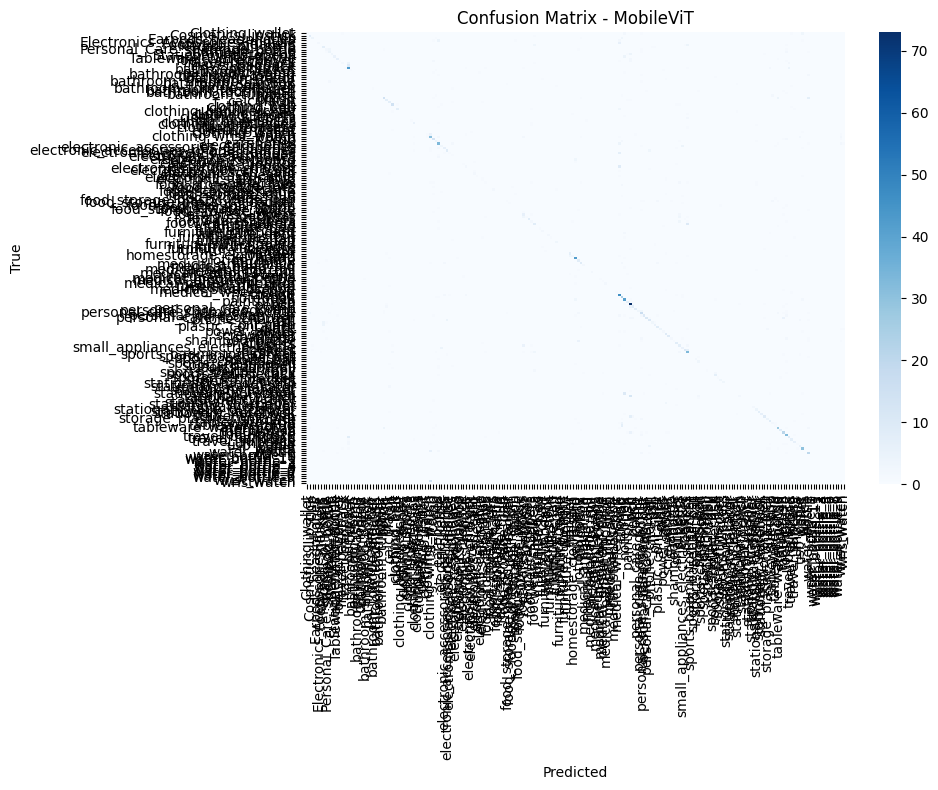

In [49]:
# 6.1 Evaluate MobileViT on validation set with detailed metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load best checkpoint if available
ckpt_path = 'best_model1_mobilevit_xxs.pth'
try:
    model1.load_state_dict(torch.load(ckpt_path, map_location=device))
    print(f"Loaded best checkpoint: {ckpt_path}")
except Exception as e:
    print(f"Could not load checkpoint: {e}. Using current model state.")

model1.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc='Eval MobileViT'):
        images = batch['image'].to(device)
        classes = batch['class'].to(device)
        outputs = model1(images)
        _, preds = torch.max(outputs['class_logits'], 1)
        true_labels.extend(classes.detach().cpu().numpy())
        pred_labels.extend(preds.detach().cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

class_names = list(val_dataset.class_encoder.classes_)
val_acc = accuracy_score(true_labels, pred_labels)
val_f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"Validation Acc: {val_acc*100:.2f}% | Validation F1: {val_f1:.4f}")
print("\nPer-class Classification Report:")
print(classification_report(true_labels, pred_labels, labels=list(range(len(class_names))), target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=list(range(len(class_names))))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MobileViT')
plt.tight_layout()
plt.show()

# Store metrics for report
deit_metrics = {
    'val_acc': float(val_acc),
    'val_f1': float(val_f1),
}



In [ ]:
run the ui file to check dont run the notebook file 